In [1]:
import torch
from torch import nn
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data.sampler import SequentialSampler
from torch.utils.data import Dataset
import numpy as np
from matplotlib import pyplot as plt
from scipy import integrate

import matplotlib.colors as mcolors
from matplotlib import rcParams

import os
#-----
from torch.utils.tensorboard import SummaryWriter

# Enable interactive plot
%matplotlib notebook
plt.style.use('pusheen')  # to poster

from matplotlib import rc

rc('text', usetex=True)
rc('font',**{'family':'serif','serif':['Palatino']})

color1 = ['#ff595e','#ffca3a','#8ac926','#1982c4','#6a4c93']
color = ['#83b692','#f9ada0', '#f9627d', '#c65b7c', '#5b3758']

## Loading dataset

In [32]:
class Propagator_Dataset(Dataset):
    
    def __init__(self, data, targets, sequence_len, total_data = 8000*1, transform=True, traj=200):
        
        self.data = data
        self.targets = targets
        self.transform = transform
        self.sequence_len = sequence_len
        self.total_data = total_data//sequence_len
        self.traj = traj
        
        self.denom = self.traj//self.sequence_len  # 0-199=200 data per file / 5 = seq len 
        
    def __getitem__(self, index):
        
        total_data = self.total_data  # 200 data by file (from 0 to 199), 1000 files(from 0 to 999), total data: 200*100 = 200000
        
        if index > total_data - 1:
            print("Error, this data does not exist")
        else:
            index_data = index#(index//self.denom)%self.denom  # because there 0-199=200 data per file / 5 = seq len 
            #index_t = (index*self.sequence_len-self.traj)%self.traj
            
            X = np.empty((self.sequence_len,96), np.float32)
            y = np.empty((self.sequence_len,64), np.float32)
            
            for i in range(self.sequence_len):
                # Input data: Wavepacket real and imaginary part + Potential at time t
                x_r = (np.load(self.data+str(index_data)+'/Wavepacket/'+str(i)+'-wave.npy')).real
                x_i = (np.load(self.data+str(index_data)+'/Wavepacket/'+str(i)+'-wave.npy')).imag
                x_p = np.load(self.data+str(index_data)+'/Potential/'+str(i)+'-potential.npy')
                
                X[i] = np.concatenate((x_r, x_i, x_p))  # flat array form
                
                # Output data: Wavepacket real and imaginary part at time t+1
                y_r = (np.load(self.targets+str(index_data)+'/Wavepacket/'+str(i+1)+'-wave.npy')).real
                y_i = (np.load(self.targets+str(index_data)+'/Wavepacket/'+str(i+1)+'-wave.npy')).imag
        
                y[i] = np.concatenate((y_r, y_i))  # flat array form
                
            '''  
            # Output data: Wavepacket real and imaginary part at time t+sequence len
            y_r = (np.load(self.targets+str(index_data)+'/Wavepacket/'+str(index_t+self.sequence_len)+'-wave.npy')).real
            y_i = (np.load(self.targets+str(index_data)+'/Wavepacket/'+str(index_t+self.sequence_len)+'-wave.npy')).imag
        
            y = np.concatenate((y_r, y_i))  # flat array form
            '''  
        
            if self.transform:
                X = torch.from_numpy(X)
                y = torch.from_numpy(y)
        
            return X, y#[None, :]
    
    def __len__(self):
        
        
        return self.total_data

In [33]:
path = '../../Data_Gaussian/data'  # Directory where are saving our data
seq_len = 1  # How many time stamps

![Ejemplo](img/example_seq_len.png)


In [34]:
dataset = Propagator_Dataset(data=path, targets=path, transform=True, sequence_len=seq_len)

In [35]:
dataset_size = len(dataset)
print('Total of data ', dataset_size)

Total of data  8000


## Training and Validation data split

In [36]:
test_split = 0.1
validation_split = 0.2  
shuffle_dataset = False
random_seed= 42

In [37]:
# Creating data indices for training and validation splits:
indices = list(range(dataset_size))
split_val = int(np.floor(validation_split * dataset_size))
split_test = int(np.floor(test_split * dataset_size))

if shuffle_dataset :
    np.random.seed(random_seed)
    np.random.shuffle(indices)
    

test_indices = indices[0:split_test] 
val_indices = indices[split_test:split_test+split_val]   
train_indices = indices[split_test+split_val:]

#train_indices, val_indices = indices[split:], indices[:split]

# Creating PT data samplers and loaders:
train_sampler = SubsetRandomSampler(train_indices)
val_sampler = SubsetRandomSampler(val_indices)
test_sampler = SubsetRandomSampler(test_indices)


# Creating PT data samplers and loaders: Sequential form:
#train_sampler = SequentialSampler(train_indices)
#test_sampler = SequentialSampler(val_indices)

In [38]:
print(f"Total of train samples: {len(train_sampler)}")
print(f"Total of validation samples: {len(val_sampler)}")
print(f"Total of test samples: {len(test_sampler)}")

Total of train samples: 5600
Total of validation samples: 1600
Total of test samples: 800


In [39]:
batch_size = 10

In [40]:
train_loader = DataLoader(dataset, batch_size=batch_size, sampler=train_sampler)
val_loader = DataLoader(dataset, batch_size=batch_size, sampler=val_sampler)
test_loader = DataLoader(dataset, batch_size=batch_size, sampler=test_sampler)

## Shape of data

In [41]:
for X, y in train_loader:
    print("Train data:")
    print(f"Shape of X in train loader: {X.shape}")
    print(f"Shape of y in train loader: {y.shape}")
    print(f"Batch size: {X.size(0)}")
    break

Train data:
Shape of X in train loader: torch.Size([10, 1, 96])
Shape of y in train loader: torch.Size([10, 1, 64])
Batch size: 10


## Visualization

In [13]:
# Display features and label.
train_features, train_labels = next(iter(train_loader))

X_vis = train_features[0].squeeze()
y_vis = train_labels[0].squeeze()

<IPython.core.display.Javascript object>


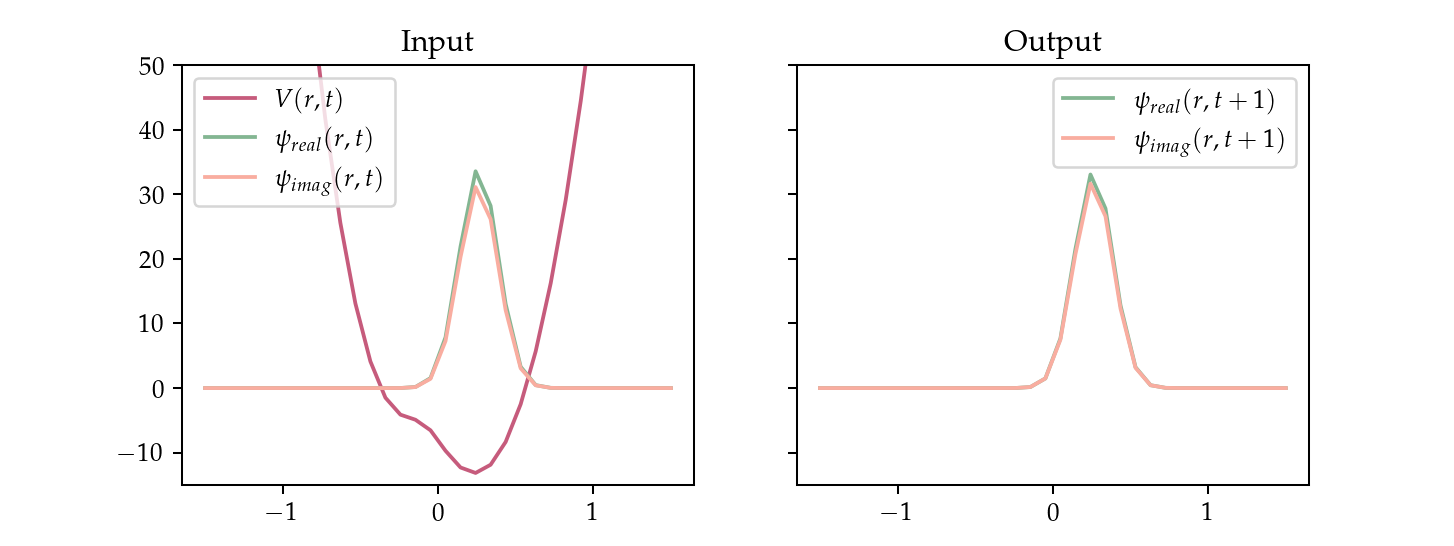

In [91]:
r_n = np.linspace(-1.5,1.5,32)
time = int(0)  # from 0 to 199

In_real_vis = X_vis[time,0:32].detach().numpy()
In_imag_vis = X_vis[time,32:64].detach().numpy()
In_pote = X_vis[time,64:96].detach().numpy()

Ou_real_vis = y_vis[time,0:32].detach().numpy()
Ou_imag_vis = y_vis[time,32:64].detach().numpy()


fig, axs = plt.subplots(1,2)


# Lenght: au -> Angstroms
axs[0].plot(r_n, In_pote*(1/1.5936e-3), "-", label="$V(r,t)$", color=color[3])
axs[0].plot(r_n, In_real_vis*30, label="$\psi_{real}(r, t)$", color = color[0])  # Escaled
axs[0].plot(r_n, In_imag_vis*30, label="$\psi_{imag}(r, t)$", color=color[1])  # Escaled
axs[0].set_title("Input")

axs[1].plot(r_n, Ou_real_vis*30, label="$\psi_{real}(r, t+1)$", color = color[0])  # Escaled
axs[1].plot(r_n, Ou_imag_vis*30, label="$\psi_{imag}(r, t+1)$", color = color[1])  # Escaled
axs[1].set_title("Output")


for axr1 in axs:
    axr1.set_ylim([-15, 50])
    axr1.legend()
    #axr1.set(xlabel='Position [$\AA$]', ylabel='Energy [Kcal/mol]')
# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()

plt.gcf().set_size_inches(8, 3)
ax.legend()
plt.show()
#plt.savefig('/home/jessica/Tesis/img/tesis/dataInputOutput.png', dpi=700)

## LSTM model
___

In [19]:
print(torch.__version__)

1.9.0+cu102


<IPython.core.display.Javascript object>


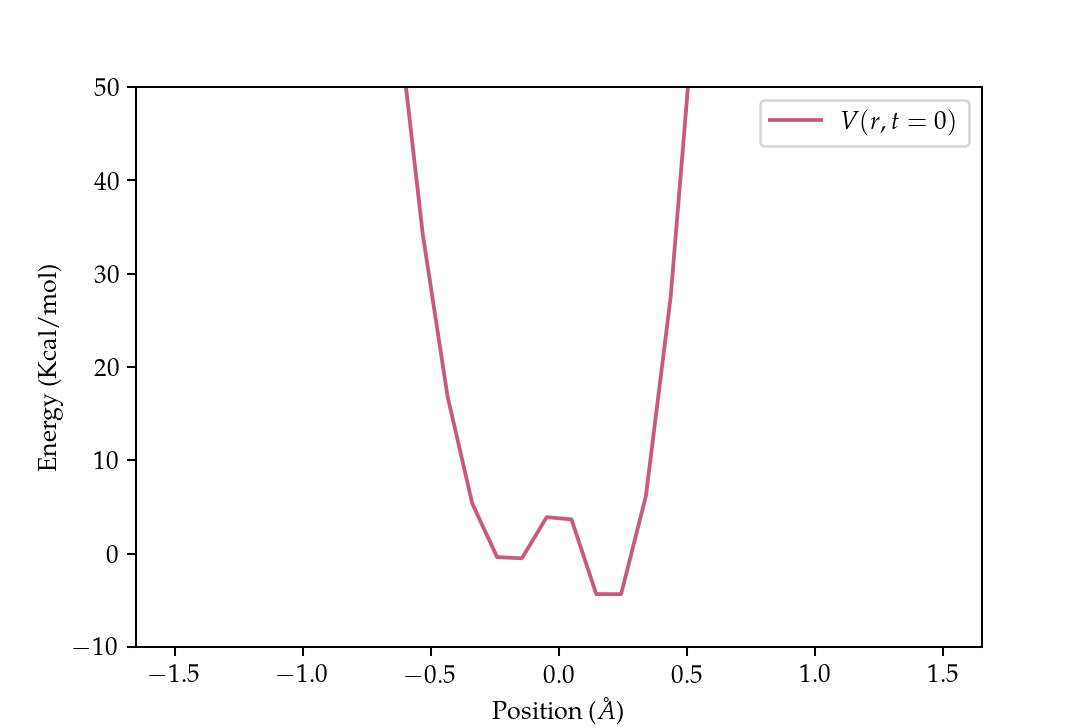

In [104]:
fig, ax = plt.subplots()
#ax.set_title(r"V(r,t)")
ax.set_xlabel('Position ($\AA$)')
ax.set_ylabel('Energy (Kcal/mol)')
ax.set_ylim([-10, 50])

ax.plot(r_n, In_pote*(1/1.5936e-3), "-", label="$V(r,t=0)$", color=color[3])
ax.legend()
plt.show()
plt.gcf().set_size_inches(6, 4)
plt.savefig('/home/jessica/Tesis/img/tesis/DataPot.png', dpi=700)

<IPython.core.display.Javascript object>


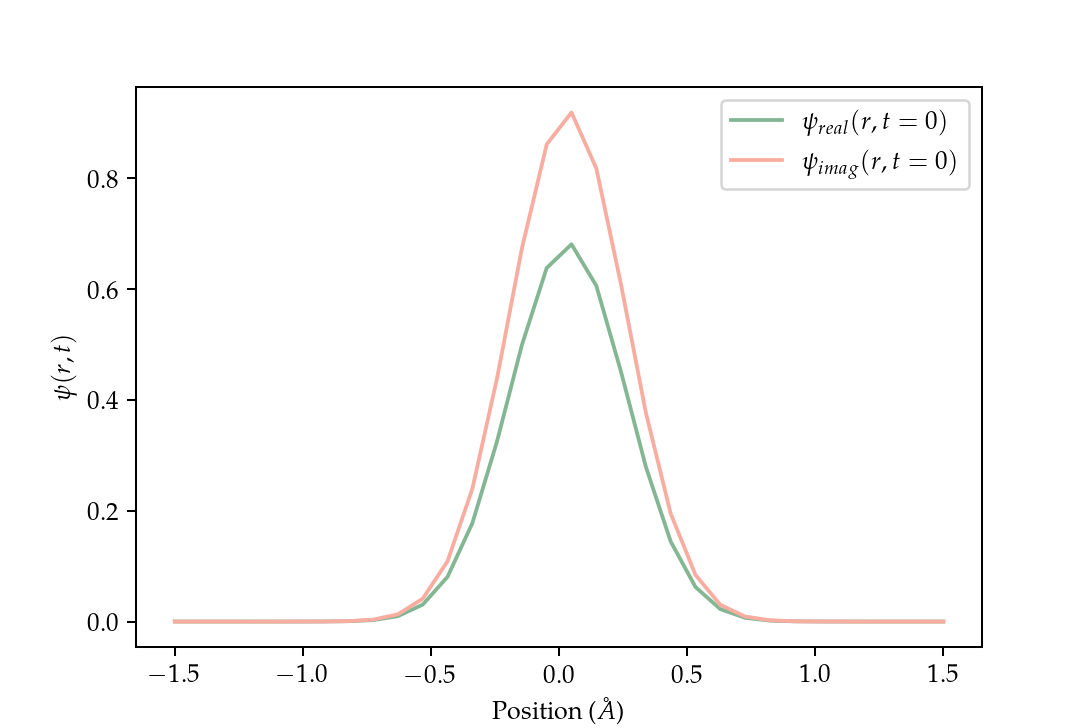

In [105]:
fig, ax = plt.subplots()
#ax.set_title(r"V(r,t)")
ax.set_xlabel('Position ($\AA$)')
ax.set_ylabel('$\psi(r,t)$')
#ax.set_ylim([-10, 50])

ax.plot(r_n, In_real_vis, label="$\psi_{real}(r, t=0)$", color = color[0])  # Escaled
ax.plot(r_n, In_imag_vis, label="$\psi_{imag}(r, t=0)$", color=color[1])  # Escaled
ax.legend()
plt.show()
plt.gcf().set_size_inches(6, 4)
plt.savefig('/home/jessica/Tesis/img/tesis/DataWave.png', dpi=700)


In [12]:
device = 'cpu'

In [13]:
class LSTM(nn.Module):
    def __init__(self, num_output, input_size, hidden_size, num_layers, seq_length):
        super(LSTM, self).__init__()
        self.num_output = num_output  # number of output
        self.num_layers = num_layers  # number of layers
        self.input_size = input_size  # input size
        self.hidden_size = hidden_size  # hidden state
        self.seq_length = seq_length  # sequence length

        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                          num_layers=num_layers, batch_first=True) #lstm
        
        #self.fc_1 =  nn.Linear(hidden_size, 1024) #fully connected 1

        #self.relu = nn.ReLU()
        
        self.fc = nn.Linear(hidden_size, num_output) #fully connected last layer
    
    def forward(self,x):
        
        h_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)) #hidden state
        c_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)) #internal state
        
        # Propagate input through LSTM
        output, (hn, cn) = self.lstm(x, (h_0, c_0)) #lstm with input, hidden, and internal state
        #hn = hn.view(-1,self.hidden_size) #reshaping the data for Dense layer next
        #out = self.relu(hn)
        #out = self.fc_1(out) #first Dense
        #out = self.relu(output) #relu
        out = self.fc(output) #Final Output
        return out

In [14]:
input_size = 96  # number of features: 32 real part +32 complex part +32 potential
hidden_size = 1024  # number of features in hidden state
num_layers = 2  # number of stacked lstm layers

num_output = 64  # number of output: 32 real part + 32 complex part
sequence_len = seq_len # lenght of time steps (1 fs each one) total 5 fs

learning_rate = 1e-4

In [18]:
# model = LSTM(num_output, input_size, hidden_size, num_layers, sequence_len) #our lstm class

In [17]:
# Initialize the loss function and optimizer
criterion = nn.MSELoss().to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)  #weight_decay=0.01 <- default

In [16]:
model = torch.load('../../src/Models/06-08-23_290EPOCHS.pth')

In [18]:
print(model)

LSTM(
  (lstm): LSTM(96, 1024, num_layers=2, batch_first=True)
  (fc): Linear(in_features=1024, out_features=64, bias=True)
)


## Accuracy function

In [17]:
def S_overlap(Psi_true, Psi_ANN):
    """
    Input:
    Psi_true: Evolution of wavepacket from dataset test, Shape: (batch size, sequence lenght, 64)
    Psi_ANN: Evolution of wavepacket predicted with the model, Shape: (batch size, sequence lenght, 64)
    
    Output:
    S: Absolute magnitude
    angle: phase
    Characterizes the quality of the predictions. See equation (11) of Main article
    
    """
    S_tot = []
    angle_tot = []
    for j in range(batch_size):
        for l in range(seq_len):
            Psi_true_re = Psi_true[j,l,0:32]  # real part of wavepacket
            Psi_true_im = Psi_true[j,l,32:64]  # imaginary part of wavepacket
            Psi_t = torch.view_as_complex(torch.stack((Psi_true_re,Psi_true_im), -1))
    
    
            Psi_ANN_re = Psi_ANN[j,l,0:32]  # realpart of wavepacket predicted
            Psi_ANN_im = -Psi_ANN[j,l,32:64]  # imaginary part of wavepacket predicted (- because conjugate)
            Psi_A = torch.view_as_complex(torch.stack((Psi_ANN_re,Psi_ANN_im), -1))
        
        
        
            overlap = []
            for i in range(32):
                overlap.append(torch.tensor([Psi_A[i]*Psi_t[i]]))
            overl = torch.tensor(overlap)
        
            # Integrate over r (real integral + complex integral)
            # Simpson method in the grid r_n (angstroms -> au)
            r_n = np.linspace(-1.5,1.5,32)*(1/0.5291775)
            overl_real = overl.real.numpy()
            overl_imag = overl.imag.numpy()
    
            real_integ = integrate.simpson(overl_real, r_n)
            imag_integ = integrate.simpson(overl_imag, r_n)
    
            # Covert to phase and magnitude of the complex result
            S_tot.append(np.sqrt(real_integ**2 + imag_integ**2))
            angle_tot.append(np.arctan(imag_integ/real_integ))
        
    S = sum(S_tot)/(batch_size*seq_len)
    angle = sum(angle_tot)/(batch_size*seq_len)
    
    return S, angle

In [ ]:
# Test over test loader
correct1 = 0
for X, y in test_loader:                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             
    X, y = X.to(device), y.to(device)
    S, angle = S_overlap(y, y)  # Accuracy by equation (11) Main Article       
    correct1 += S
correct1 /= len(test_loader)
print(f"Test Error: \n Accuracy: {(100*correct1):>0.1f}%\n")  # Should be 100% because y=y => main of |S| = 1

In [24]:
writer = SummaryWriter(comment="Update2LSTM_1024neu_seq200_BATCH_10_LR_1E-4_4700DATA")  # To use tensorboard

In [23]:
for X,y in train_loader:
    writer.add_graph(model,X)  # to draw diagram model
    break

## Train & Test loop definition

In [25]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader)#len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.squeeze().to(device)

        # Compute prediction error
        pred = model(X.float()).squeeze()
        loss = loss_fn(pred, y.float())
        
        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), batch
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
    
    writer.add_scalar("Loss/train", loss.item(), epoch)


In [26]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correctS, correct_phase = 0, 0, 0
    
    with torch.no_grad():
        for X, y in dataloader:                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             
            X, y = X.to(device), y.to(device)
            pred = model(X.float())
            test_loss += loss_fn(pred, y).item()
            S, angle = S_overlap(y, pred)  
            correctS += S
            correct_phase += angle
    
    correctS /= num_batches
    correct_phase /= num_batches
    test_loss /= num_batches
    
    writer.add_scalar('Accuracy Magnitude |S| /test', 100*correctS, epoch)  # Should be 100%
    writer.add_scalar('Accuracy phase /test', correct_phase, epoch)  # Should be 0
    writer.add_scalar("Loss/validation", test_loss, epoch)

    

    print(f"Test Error: \n Accuracy Magnitude |S|: {(100*correctS):>0.1f}%")
    print(f"Test Error: \n Accuracy phase: {(correct_phase):>0.1f}\n")

## Training

In [31]:
epochs = 290
for epoch in range(260,epochs):
    print(f"Epoch {epoch+1}\n-------------------------------")
    train(train_loader, model, criterion, optimizer)
    test(val_loader, model, criterion)
    
writer.flush()

Epoch 261
-------------------------------
loss: 0.001721  [    0/  560]
loss: 0.001555  [  100/  560]
loss: 0.006242  [  200/  560]
loss: 0.003749  [  300/  560]
loss: 0.001069  [  400/  560]
loss: 0.001920  [  500/  560]
Test Error: 
 Accuracy Magnitude |S|: 94.1%
Test Error: 
 Accuracy phase: 0.0

Epoch 262
-------------------------------
loss: 0.001570  [    0/  560]
loss: 0.007451  [  100/  560]
loss: 0.001341  [  200/  560]
loss: 0.002708  [  300/  560]
loss: 0.006241  [  400/  560]
loss: 0.009322  [  500/  560]
Test Error: 
 Accuracy Magnitude |S|: 94.1%
Test Error: 
 Accuracy phase: 0.0

Epoch 263
-------------------------------
loss: 0.002297  [    0/  560]
loss: 0.003183  [  100/  560]
loss: 0.005279  [  200/  560]
loss: 0.004688  [  300/  560]
loss: 0.001661  [  400/  560]
loss: 0.002091  [  500/  560]
Test Error: 
 Accuracy Magnitude |S|: 94.0%
Test Error: 
 Accuracy phase: -0.0

Epoch 264
-------------------------------
loss: 0.002158  [    0/  560]
loss: 0.005928  [  100/ 

loss: 0.001776  [  100/  560]
loss: 0.001950  [  200/  560]
loss: 0.002232  [  300/  560]
loss: 0.002201  [  400/  560]
loss: 0.002082  [  500/  560]
Test Error: 
 Accuracy Magnitude |S|: 94.1%
Test Error: 
 Accuracy phase: 0.0

Epoch 289
-------------------------------
loss: 0.004525  [    0/  560]
loss: 0.000764  [  100/  560]
loss: 0.002827  [  200/  560]
loss: 0.001693  [  300/  560]
loss: 0.006661  [  400/  560]
loss: 0.002344  [  500/  560]
Test Error: 
 Accuracy Magnitude |S|: 94.2%
Test Error: 
 Accuracy phase: -0.0

Epoch 290
-------------------------------
loss: 0.001433  [    0/  560]
loss: 0.001900  [  100/  560]
loss: 0.004155  [  200/  560]
loss: 0.001718  [  300/  560]
loss: 0.001428  [  400/  560]
loss: 0.000967  [  500/  560]
Test Error: 
 Accuracy Magnitude |S|: 94.2%
Test Error: 
 Accuracy phase: 0.0



In [32]:
torch.save(model, '../../Models/06-08-23_290EPOCHS.pth')

In [20]:
model1 = torch.load('../Models/06-08-23_220EPOCHS.pth')
model2 = torch.load('../Models/06-08-23_240EPOCHS.pth')
model3 = torch.load('../Models/06-08-23_260EPOCHS.pth')
model4 = torch.load('../Models/06-08-23_290EPOCHS.pth')

In [24]:
# Initialize the loss function and optimizer
criterion = nn.MSELoss().to(device)
#optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)  #weight_decay=0.01 <- default

## Accuracy Test New Data

In [25]:
def test1(dataloader, model, loss_fn):
    '''
    Same as test function but without writer to tensorboard
    '''
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correctS, correct_phase = 0, 0, 0
    
    with torch.no_grad():
        for X, y in dataloader:                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             
            X, y = X.to(device), y.to(device)
            pred = model(X.float())
            test_loss += loss_fn(pred, y).item()
            S, angle = S_overlap(y,pred)  
            correctS += S
            correct_phase += angle
    
    correctS /= num_batches
    correct_phase /= num_batches

    print(f"Test Error: \n Accuracy Magnitude |S|: {(100*correctS):>0.1f}%")
    print(f"Test Error: \n Accuracy phase: {(correct_phase):>0.1f}\n")

In [27]:
test1(test_loader, model2, criterion)

Test Error: 
 Accuracy Magnitude |S|: 94.3%
Test Error: 
 Accuracy phase: -0.0



|Model Name: 06-08-23_--EPOCHS.pth|
|--- |

|Epoch | Accuracy Magnitude | Accuracy phase |
| --- | --- | --- |
|220 | 94.1%| 0.0015 |
|240 | 94.3%| -0.014 |
|260 | 94.4%| -0.003 |
|290 | 94.6%| 0.0001|

In [28]:
model = torch.load('../Models/06-08-23_290EPOCHS.pth')

## Predictions wavepackets

In [19]:
test_loader

In [42]:
%%time
for X,y in test_loader:
    X, y = X.to(device), y.to(device)
    
    Entrada = X
    
    Salida = y

    with torch.inference_mode():
        Prediccion = model(X.float())
    break

CPU times: user 53.6 ms, sys: 79 µs, total: 53.6 ms
Wall time: 53.6 ms


In [113]:
print(Entrada.shape)
print(Prediccion.shape)
print(Salida.shape)

torch.Size([10, 200, 96])
torch.Size([10, 200, 64])
torch.Size([10, 200, 64])


In [163]:


time = int(105)

In_real_vis = Entrada[2,time,0:32].detach().numpy()
In_imag_vis = Entrada[2,time,32:64].detach().numpy()
Pote = Entrada[2,time,64:96].detach().numpy()

Ou_real_vis = Salida[2,time,0:32].detach().numpy()
Ou_imag_vis = Salida[2,time,32:64].detach().numpy()
Pote_next = Entrada[2,time+1,64:96].detach().numpy()

Pred_real_vis = Prediccion[2,time,0:32].detach().numpy()
Pred_imag_vis = Prediccion[2,time,32:64].detach().numpy()

<IPython.core.display.Javascript object>


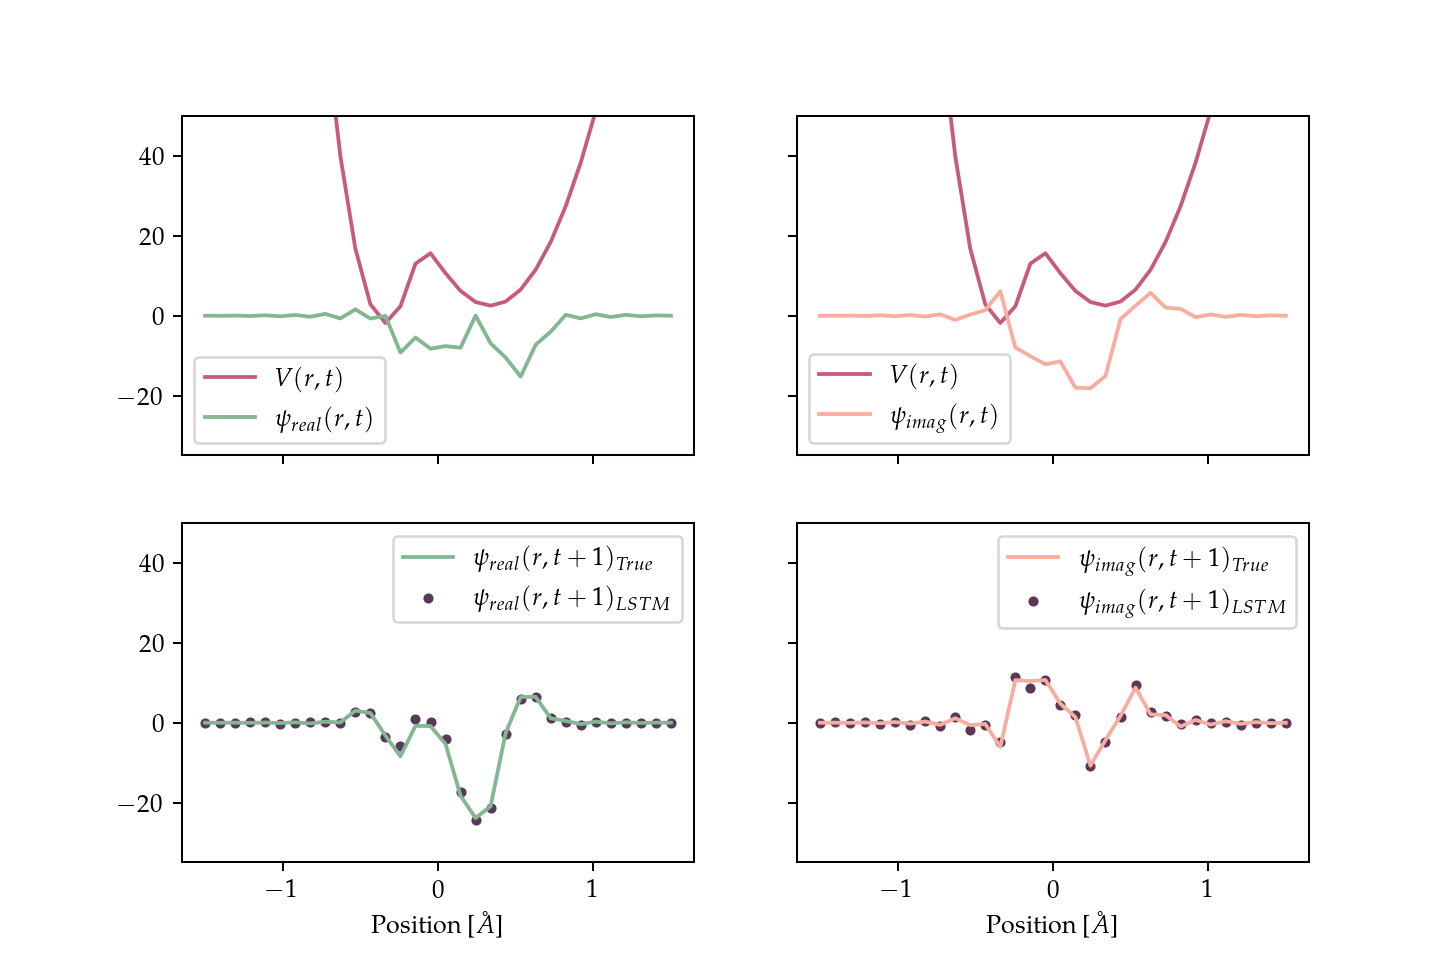

In [164]:
fig, axs = plt.subplots(2,2)

# Lenght: au -> Angstroms
axs[0,0].plot(r_n, Pote*(1/1.5936e-3), "-", label="$V(r,t)$", color=color[3])
axs[0,0].plot(r_n, In_real_vis*20, label="$\psi_{real}(r, t)$", color=color[0])  # Escaled


axs[0,1].plot(r_n, Pote*(1/1.5936e-3), "-", label="$V(r,t)$", color=color[3])
axs[0,1].plot(r_n, In_imag_vis*20, label="$\psi_{imag}(r, t)$", color =color[1])  # Escaled

#axs[0].plot(r_n, Pote_next*(1/1.5936e-3), "-", label="V(r,t)", color=color[3])
axs[1,0].plot(r_n, Ou_real_vis*20, label="$\psi_{real}(r, t+1)_{True}$", color=color[0])  # Escaled
axs[1,0].scatter(r_n, Pred_real_vis*20, label="$\psi_{real}(r, t+1)_{LSTM}$", color=color[4], marker='.')  # Escaled
 

axs[1,1].plot(r_n, Ou_imag_vis*20, label="$\psi_{imag}(r, t+1)_{True}$", color =color[1])  # Escaled
axs[1,1].scatter(r_n, Pred_imag_vis*20, label="$\psi_{imag}(r, t+1)_{LSTM}$", color =color[4], marker='.')  # Escaled


# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()
    ax.set_ylim([-35,50])
    ax.legend()
    ax.set(xlabel='Position [$\AA$]')
    ax.label_outer()
 

plt.gcf().set_size_inches(8, 5.33)
plt.legend()    
plt.show()
plt.savefig('/home/jessica/Tesis/img/tesis/model/1step4.png', dpi=700)


## Predictions density

In [34]:
for X,y in test_loader:
    X, y = X.to(device), y.to(device)
    
    Entrada = X
    
    Salida = y

    with torch.inference_mode():
        Prediccion = model(X.float())
    break

In [35]:
#------------- t=0
In_real_vis0 = Entrada[2,0,0:32].detach().numpy()
In_imag_vis0 = Entrada[2,0,32:64].detach().numpy()
In_dens0 = (np.abs(np.vectorize(complex)(In_real_vis0,In_imag_vis0)))**2

Pote0 = Entrada[2,0,64:96].detach().numpy()


#------------ t=40 fs
Ou_real_vis0 = Salida[2,40,0:32].detach().numpy()
Ou_imag_vis0 = Salida[2,40,32:64].detach().numpy()
Ou_dens0 = (np.abs(np.vectorize(complex)(Ou_real_vis0,Ou_imag_vis0)))**2
      
Pred_real_vis0 = Prediccion[2,40,0:32].detach().numpy()
Pred_imag_vis0 = Prediccion[2,40,32:64].detach().numpy()
Pred_dens0 = (np.abs(np.vectorize(complex)(Pred_real_vis0,Pred_imag_vis0)))**2

#-------------- t=80 fs
In_real_vis1 = Entrada[2,80,0:32].detach().numpy()
In_imag_vis1 = Entrada[2,80,32:64].detach().numpy()
Pote1 = Entrada[2,80,64:96].detach().numpy()

Ou_real_vis1 = Salida[2,80,0:32].detach().numpy()
Ou_imag_vis1 = Salida[2,80,32:64].detach().numpy()
Ou_dens1 = (np.abs(np.vectorize(complex)(Ou_real_vis1,Ou_imag_vis1)))**2

Pred_real_vis1 = Prediccion[2,80,0:32].detach().numpy()
Pred_imag_vis1 = Prediccion[2,80,32:64].detach().numpy()
Pred_dens1 = (np.abs(np.vectorize(complex)(Pred_real_vis1,Pred_imag_vis1)))**2

#-------------- t=120 fs
In_real_vis2 = Entrada[2,120,0:32].detach().numpy()
In_imag_vis2 = Entrada[2,120,32:64].detach().numpy()
Pote2 = Entrada[2,120,64:96].detach().numpy()

Ou_real_vis2 = Salida[2,120,0:32].detach().numpy()
Ou_imag_vis2 = Salida[2,120,32:64].detach().numpy()
Ou_dens2 = (np.abs(np.vectorize(complex)(Ou_real_vis2,Ou_imag_vis2)))**2

Pred_real_vis2 = Prediccion[2,120,0:32].detach().numpy()
Pred_imag_vis2 = Prediccion[2,120,32:64].detach().numpy()
Pred_dens2 = (np.abs(np.vectorize(complex)(Pred_real_vis2,Pred_imag_vis2)))**2

#-------------- t=160 fs
In_real_vis3 = Entrada[2,160,0:32].detach().numpy()
In_imag_vis3 = Entrada[2,160,32:64].detach().numpy()
Pote3 = Entrada[2,160,64:96].detach().numpy()

Ou_real_vis3 = Salida[2,160,0:32].detach().numpy()
Ou_imag_vis3 = Salida[2,160,32:64].detach().numpy()
Ou_dens3 = (np.abs(np.vectorize(complex)(Ou_real_vis3,Ou_imag_vis3)))**2

Pred_real_vis3 = Prediccion[2,160,0:32].detach().numpy()
Pred_imag_vis3 = Prediccion[2,160,32:64].detach().numpy()
Pred_dens3 = (np.abs(np.vectorize(complex)(Pred_real_vis3,Pred_imag_vis3)))**2

#-------------- t=200 fs
In_real_vis4 = Entrada[2,199,0:32].detach().numpy()
In_imag_vis4 = Entrada[2,199,32:64].detach().numpy()
Pote4 = Entrada[2,199,64:96].detach().numpy()

Ou_real_vis4 = Salida[2,199,0:32].detach().numpy()
Ou_imag_vis4 = Salida[2,199,32:64].detach().numpy()
Ou_dens4 = (np.abs(np.vectorize(complex)(Ou_real_vis4,Ou_imag_vis4)))**2

Pred_real_vis4 = Prediccion[2,199,0:32].detach().numpy()
Pred_imag_vis4 = Prediccion[2,199,32:64].detach().numpy()
Pred_dens4 = (np.abs(np.vectorize(complex)(Pred_real_vis4,Pred_imag_vis4)))**2

r_n = np.linspace(-1.5,1.5,32)



<IPython.core.display.Javascript object>


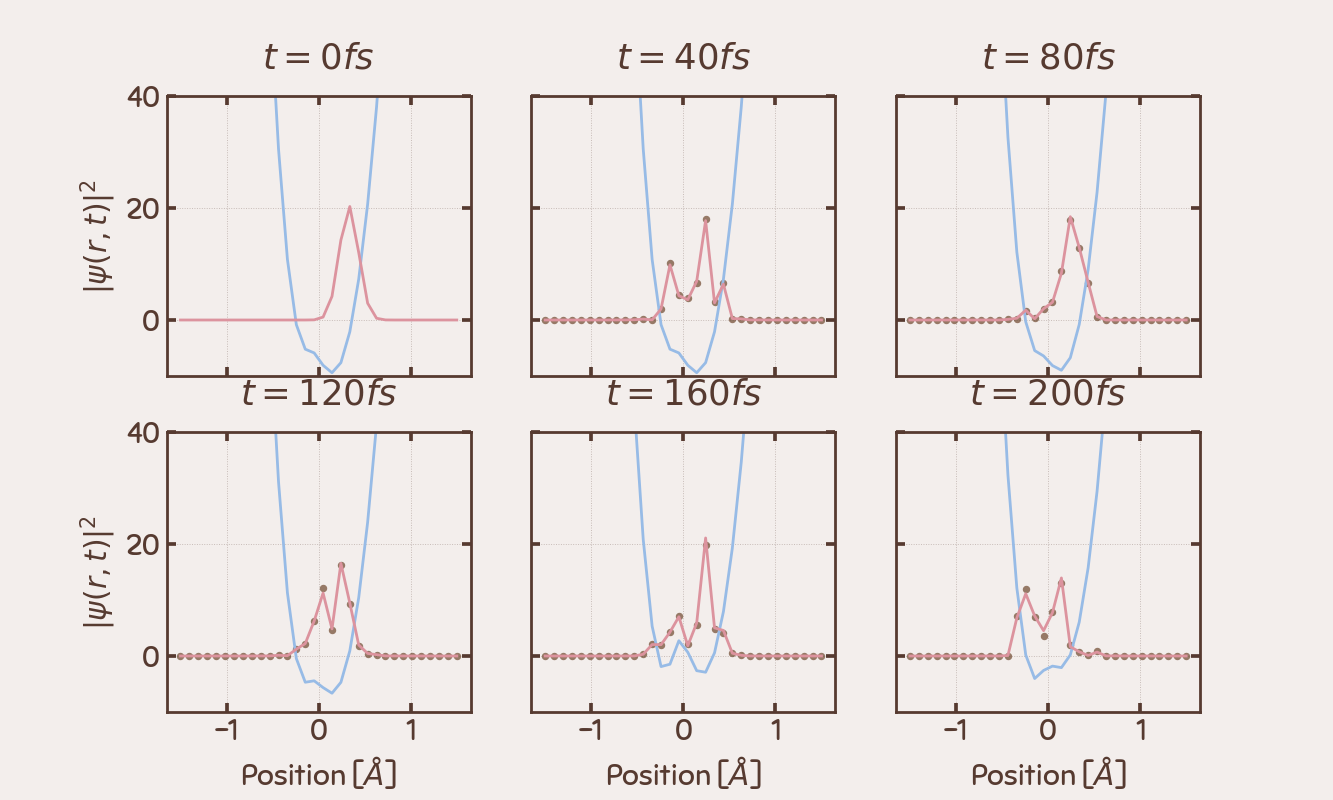

In [44]:
fig, ax = plt.subplots(2,3)

    
# Time: fs -> au, Lenght: au -> Angstroms, Energy: au -> kcal/mol
ax[0,0].plot(r_n, Pote0*(1/1.5936e-3), "-", label="$V(r,t)$", color='C4')
ax[0,0].plot(r_n, In_dens0*10, label="$|\psi_{initial}|^{2}$")
ax[0,0].set_title("$t=0 fs$")



ax[0,1].plot(r_n, Pote0*(1/1.5936e-3), "-", label="$V(r,t)$", color='C4')
ax[0,1].scatter(r_n, Pred_dens0*10, label="$|\psi_{LSTM}|^{2}$", color='C1', marker='.')
ax[0,1].plot(r_n, Ou_dens0*10, label="$|\psi_{True}|^{2}$", color='C0')
ax[0,1].set_title("$t=40 fs$")

ax[0,2].plot(r_n, Pote1*(1/1.5936e-3), "-", label="$V(r, t)$", color='C4')
ax[0,2].scatter(r_n, Pred_dens1*10, label="$|\psi_{LSTM}|^{2}$", color='C1', marker='.')
ax[0,2].plot(r_n, Ou_dens1*10, label="$|\psi_{True}|^{2}$")
ax[0,2].set_title("$t=80 fs$")

ax[1,0].plot(r_n, Pote2*(1/1.5936e-3), "-", label="$V(r, t)$", color='C4')
ax[1,0].scatter(r_n, Pred_dens2*(10), label="$|\psi_{LSTM}|^{2}$", color='C1', marker='.')
ax[1,0].plot(r_n, Ou_dens2*10, label="$|\psi_{True}|^{2}$")
ax[1,0].set_title("$t=120 fs$")

ax[1,1].plot(r_n, Pote3*(1/1.5936e-3), "-", label="$V(r,t)$", color='C4')
ax[1,1].scatter(r_n, Pred_dens3*(10), label="$|\psi_{LSTM}|^{2}$", color='C1', marker='.')
ax[1,1].plot(r_n, Ou_dens3*10, label="$|\psi_{True}|^{2}$")
ax[1,1].set_title("$t=160 fs$")

ax[1,2].plot(r_n, Pote4*(1/1.5936e-3), "-", label="$V(r,t)$", color='C4')
ax[1,2].scatter(r_n, Pred_dens4*(10), label="$|\psi_{LSTM}|^{2}$", color='C1', marker='.')
ax[1,2].plot(r_n, Ou_dens4*10, label="$|\psi_{True}|^{2}$")
ax[1,2].set_title("$t=200 fs$")







for axr1 in ax:
    for axr11 in axr1:
        axr11.set_ylim([-10, 40])
        #axr11.legend()
        axr11.set(xlabel='Position [$\AA$]')
        axr11.set(ylabel='$|\psi(r,t)|^{2}$')
        
# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in ax.flat:
    ax.label_outer()
    
    
plt.gcf().set_size_inches(10, 6)
#plt.legend()    
plt.show()
plt.savefig('/home/jessica/Tesis/Poster/img/Preddens.png', dpi=700)

### Saving data to animation

In [312]:
Entrada[:,:,64:96].shape

torch.Size([10, 200, 32])

In [249]:
newPred = Prediccion.numpy()  # By model real & imag part
newSal = Salida.numpy()  # Analitical real & imag part
Poten = Entrada[:,:,64:96].numpy()  # Potential

In [250]:
with open(os.path.join('../Animacion/ModelLSTM-32size/prediccion.npy'), 'wb') as f:
    np.save(f, newPred)

In [251]:
with open(os.path.join('../Animacion/ModelLSTM-32size/salida.npy'), 'wb') as f:
    np.save(f, newSal)

In [252]:
with open(os.path.join('../Animacion/ModelLSTM-32size/potencial.npy'), 'wb') as f:
    np.save(f, Poten)

## New trajectory

Para asegurar que la red funciona xd

In [39]:
path_test = '../../NewTrajectories/data'  # Directory where are a total new trajectory
seq_len = 200  # How many time stamps

In [40]:
dataset_newTest = Propagator_Dataset(data=path_test, targets=path_test, transform=True, sequence_len=seq_len, total_data = 1*200)

In [41]:
newTraj = DataLoader(dataset_newTest)

In [42]:
for X,y in newTraj:
    X, y = X.to(device), y.to(device)
    
    Entrada = X
    
    Salida = y
    with torch.inference_mode():
        Prediccion = model(X.float())
    break

In [43]:
print(Entrada.shape)
print(Prediccion.shape)
print(Salida.shape)

torch.Size([1, 200, 96])
torch.Size([1, 200, 64])
torch.Size([1, 200, 64])


In [47]:
r_n = np.linspace(-1.5,1.5,32)

time = int(60)  # from 0 to 199 fs

In_real_vis = Entrada[0,time,0:32].detach().numpy()
In_imag_vis = Entrada[0,time,32:64].detach().numpy()
Pote = Entrada[0,time,64:96].detach().numpy()

Ou_real_vis = Salida[0,time,0:32].detach().numpy()
Ou_imag_vis = Salida[0,time,32:64].detach().numpy()
Pote_next = Entrada[0,time+1,64:96].detach().numpy()

Pred_real_vis = Prediccion[0,time,0:32].detach().numpy()
Pred_imag_vis = Prediccion[0,time,32:64].detach().numpy()

<IPython.core.display.Javascript object>


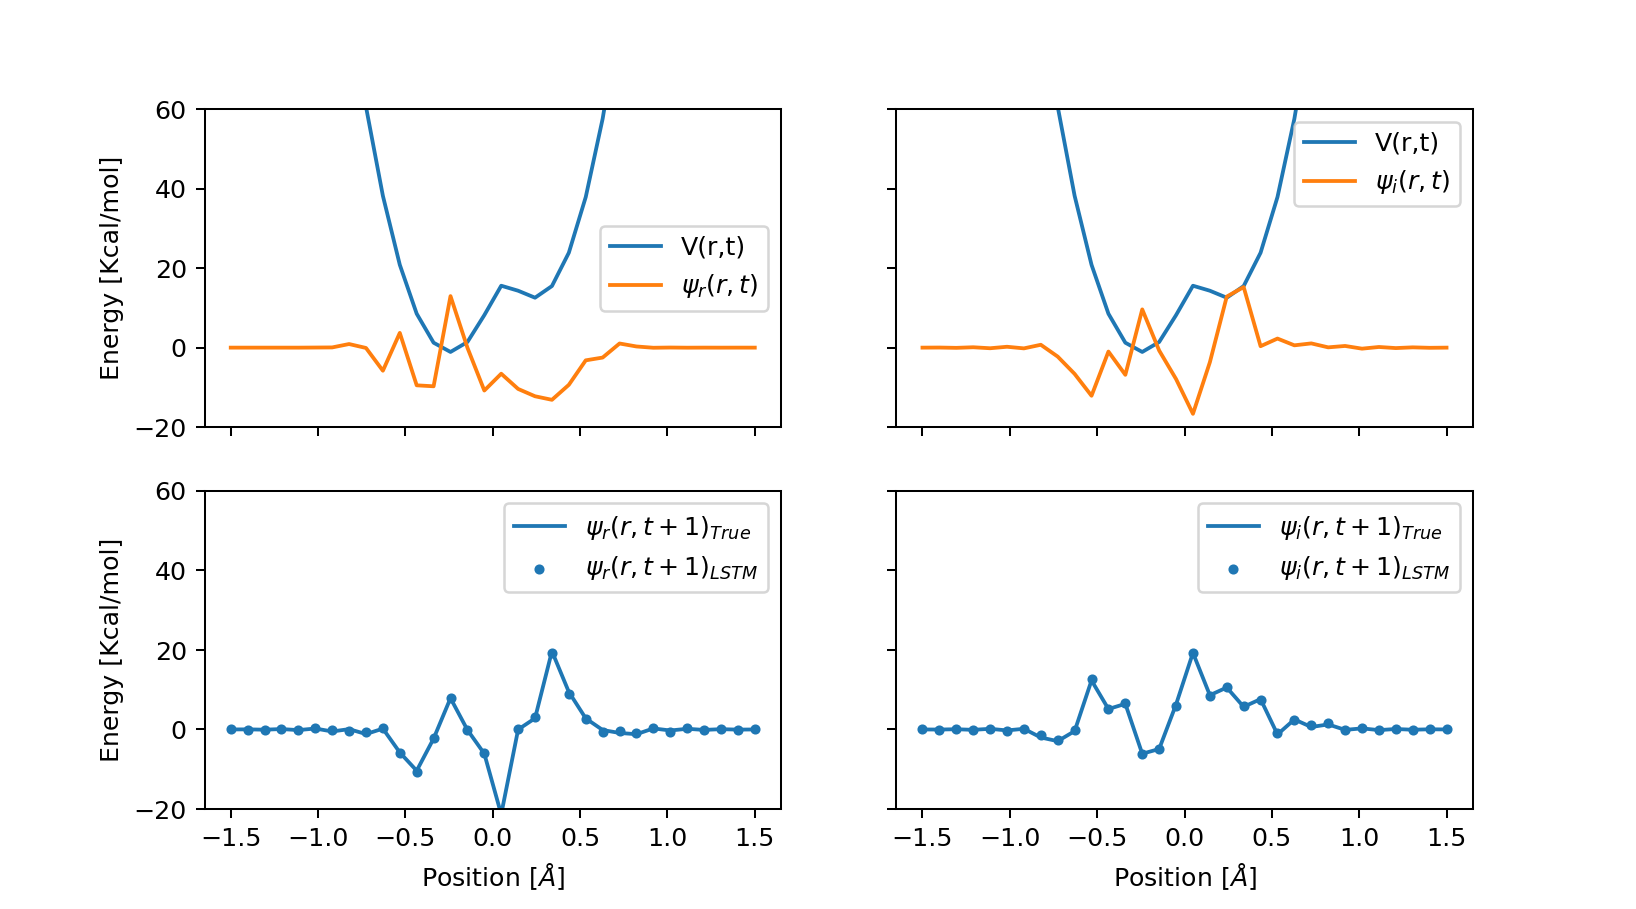

In [48]:
fig, axs = plt.subplots(2,2)

# Lenght: au -> Angstroms
axs[0,0].plot(r_n, Pote*(1/1.5936e-3), "-", label="V(r,t)")
axs[0,0].plot(r_n, In_real_vis*20, label="$\psi_{r}(r, t)$")  # Escaled


axs[0,1].plot(r_n, Pote*(1/1.5936e-3), "-", label="V(r,t)")
axs[0,1].plot(r_n, In_imag_vis*20, label="$\psi_{i}(r, t)$")  # Escaled

#axs[0].plot(r_n, Pote_next*(1/1.5936e-3), "-", label="V(r,t)", color=color[3])
axs[1,0].plot(r_n, Ou_real_vis*20, label="$\psi_{r}(r, t+1)_{True}$")  # Escaled
axs[1,0].scatter(r_n, Pred_real_vis*20, label="$\psi_{r}(r, t+1)_{LSTM}$", marker='.')  # Escaled


axs[1,1].plot(r_n, Ou_imag_vis*20, label="$\psi_{i}(r, t+1)_{True}$")  # Escaled
axs[1,1].scatter(r_n, Pred_imag_vis*20, label="$\psi_{i}(r, t+1)_{LSTM}$", marker='.')  # Escaled

for axr1 in axs:
    for axr11 in axr1:
        axr11.set_ylim([-20, 60])
        axr11.legend()
        axr11.set(xlabel='Position [$\AA$]', ylabel='Energy [Kcal/mol]')
# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()
    
plt.gcf().set_size_inches(9, 5)
plt.legend()    
plt.show()

yes it works

## Loss and S
___

Value
30.764490127563477
42.1784782409668
48.41368103027344
51.832679748535156
56.589691162109375
60.65315628051758
63.27207946777344
65.20655059814453
68.29475402832031
69.5735855102539
71.21925354003906
72.9779052734375
74.29841613769531
75.4523696899414
76.3133773803711
77.54633331298828
77.8699951171875
78.86125183105469
79.65210723876953
80.06941986083984
80.39693450927734
80.85676574707031
81.29371643066406
82.03409576416016
82.635498046875
82.59478759765625
83.27401733398438
83.1311264038086
83.71269226074219
84.13579559326172
84.08844757080078
84.51237487792969
84.70770263671875
84.48627471923828
85.48455047607422
85.48628997802734
85.81134033203125
85.91193389892578
85.79728698730469
86.06627655029297
86.49259185791016
86.58613586425781
86.48560333251953
86.76090240478516
86.67726135253906
86.51457214355469
87.09136199951172
87.44318389892578
87.21922302246094
87.43355560302734
87.5876693725586
87.63800811767578
88.28529357910156
87.78804016113281
88.11040496826172
88.23820495

In [107]:
import csv

fileS1 = '../runs/Aug06_16-54-53_Aldos-MBP.fritz.boxUpdate2LSTM_1024neu_seq200_BATCH_10_LR_1E-4_4700DATA/Aug06.csv'
fileS2 = '../runs/Aug06_16-54-53_Aldos-MBP.fritz.boxUpdate2LSTM_1024neu_seq200_BATCH_10_LR_1E-4_4700DATA/Aug12-S.csv.csv'

fileT1 = '../runs/Aug06_16-54-53_Aldos-MBP.fritz.boxUpdate2LSTM_1024neu_seq200_BATCH_10_LR_1E-4_4700DATA/Aug06-tetha.csv'
fileT2 = '../runs/Aug06_16-54-53_Aldos-MBP.fritz.boxUpdate2LSTM_1024neu_seq200_BATCH_10_LR_1E-4_4700DATA/Aug12-tetha.csv'

fileLTra1 = '../runs/Aug06_16-54-53_Aldos-MBP.fritz.boxUpdate2LSTM_1024neu_seq200_BATCH_10_LR_1E-4_4700DATA/Aug06-lossTrain.csv'
fileLTra2 = '../runs/Aug06_16-54-53_Aldos-MBP.fritz.boxUpdate2LSTM_1024neu_seq200_BATCH_10_LR_1E-4_4700DATA/Aug12-lossTrain.csv'

fileLTe1 = '../runs/Aug06_16-54-53_Aldos-MBP.fritz.boxUpdate2LSTM_1024neu_seq200_BATCH_10_LR_1E-4_4700DATA/Aug06-lossTest.csv'
fileLTe2 = '../runs/Aug06_16-54-53_Aldos-MBP.fritz.boxUpdate2LSTM_1024neu_seq200_BATCH_10_LR_1E-4_4700DATA/Aug12-lossTest.csv'






In [108]:
import pandas as pd
#headers = ['Wall time', 'Step', 'Value']

dfS1 = pd.read_csv(fileS1)
dfS2 = pd.read_csv(fileS2)

dfT1 = pd.read_csv(fileT1)
dfT2 = pd.read_csv(fileT2)

dfLTra1 = pd.read_csv(fileLTra1)
dfLTra2 = pd.read_csv(fileLTra2)

dfLTe1 = pd.read_csv(fileLTe1)
dfLTe2 = pd.read_csv(fileLTe2)


In [109]:
dfS = pd.concat([dfS1, dfS2], ignore_index=True, sort=False)
dfth = pd.concat([dfT1, dfT2], ignore_index=True, sort=False)
dfLTra = pd.concat([dfLTra1, dfLTra2], ignore_index=True, sort=False)
dfLTe = pd.concat([dfLTe1, dfLTe2], ignore_index=True, sort=False)

In [130]:
dfS.tail

<bound method NDFrame.tail of         Wall time  Step      Value
0    1.691336e+09     0  30.764490
1    1.691337e+09     1  42.178478
2    1.691339e+09     2  48.413681
3    1.691341e+09     3  51.832680
4    1.691342e+09     4  56.589691
..            ...   ...        ...
285  1.691912e+09   285  94.303131
286  1.691914e+09   286  94.218391
287  1.691916e+09   287  94.110893
288  1.691918e+09   288  94.201874
289  1.691919e+09   289  94.163315

[290 rows x 3 columns]>

<IPython.core.display.Javascript object>


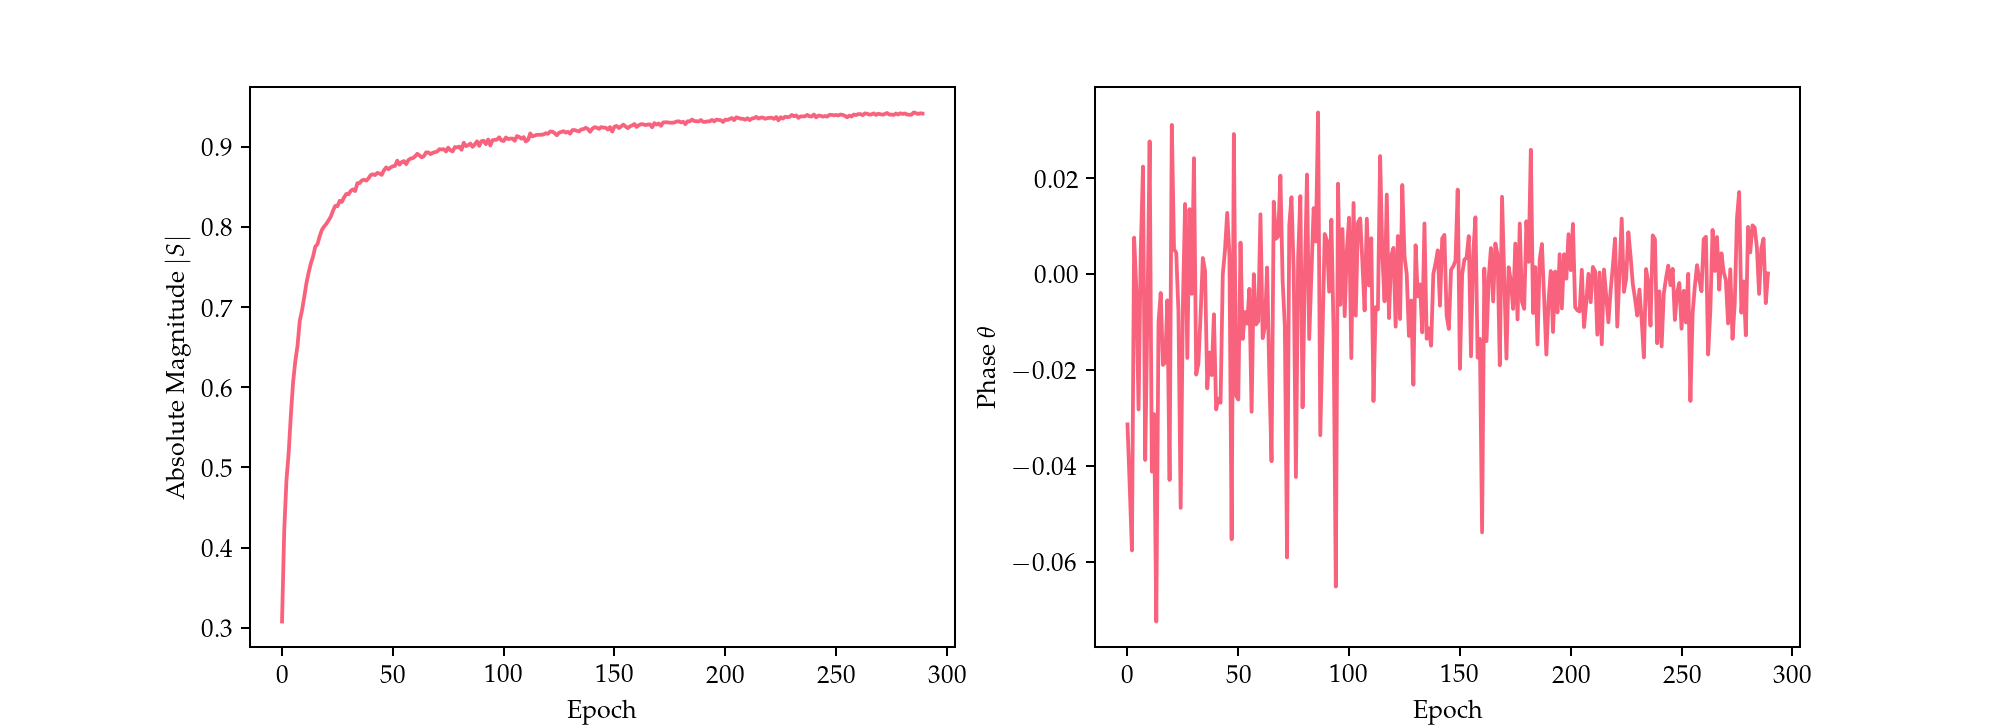

In [101]:
#dfS.plot(x = 'Step', y = 'Value')
fig, ax = plt.subplots(1,2)

ax[0].plot(dfS["Step"], dfS["Value"]*0.01, color=color[2])
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Absolute Magnitude $|S|$')

ax[1].plot(dfS["Step"], dfth["Value"], color=color[2])
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel(r'Phase $\theta$')


plt.gcf().set_size_inches(11, 4)
plt.savefig('/home/jessica/Tesis/img/tesis/S-plot.png', dpi=700)
plt.show()

In [121]:
def my_tb_smooth(scalars: list[float], weight: float) -> list[float]:  # Weight between 0 and 1
    """

    ref: https://stackoverflow.com/questions/42011419/is-it-possible-to-call-tensorboard-smooth-function-manually

    :param scalars:
    :param weight:
    :return:
    """
    last = scalars[0]  # First value in the plot (first timestep)
    smoothed: list = []
    for point in scalars:
        smoothed_val = last * weight + (1 - weight) * point  # Calculate smoothed value
        smoothed.append(smoothed_val)                        # Save it
        last = smoothed_val                                  # Anchor the last smoothed value
    return smoothed

In [127]:
anu = my_tb_smooth(dfLTra["Value"], 0.9)

<IPython.core.display.Javascript object>


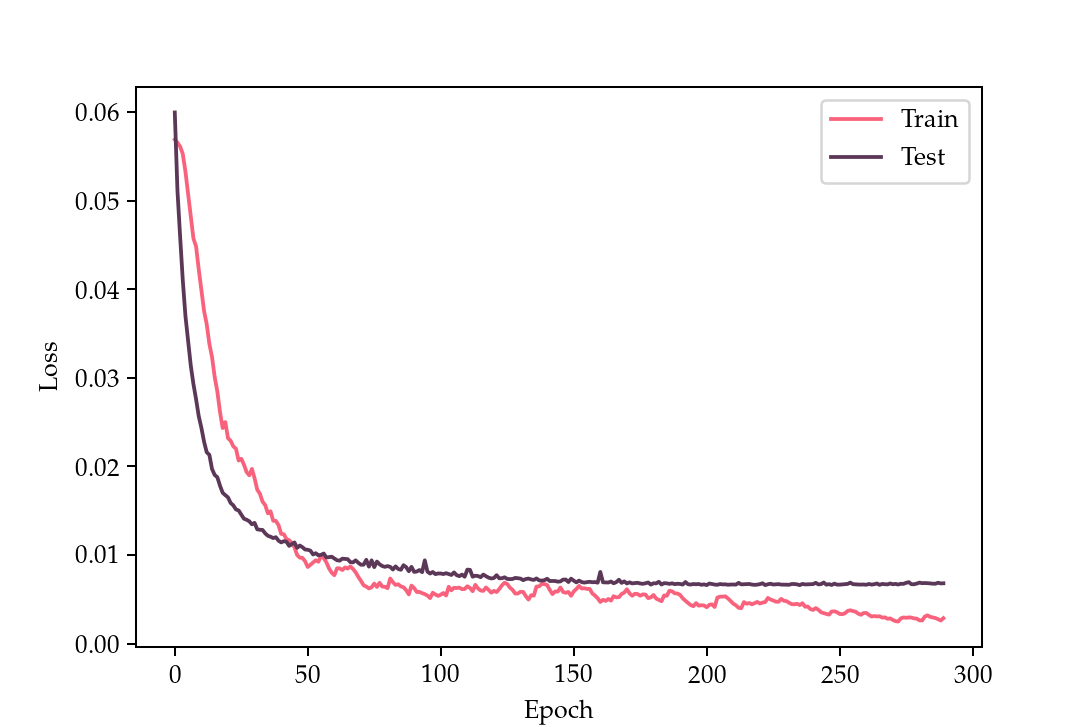

In [129]:
fig, ax = plt.subplots()

ax.plot(dfS["Step"], anu, color=color[2], label='Train')
ax.plot(dfS["Step"], dfLTe["Value"], color=color[4], label='Test')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')



plt.legend()
plt.gcf().set_size_inches(6, 4)
plt.savefig('/home/jessica/Tesis/img/tesis/Loss-plot.png', dpi=700)
plt.show()